In [17]:
import pandas as pd
from googleapiclient.discovery import build

#api key
API_KEY = "Your-API-Key"

In [2]:
def get_trending_videos(api_key, max_results=200):
    #build the yputube service
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    #initialize an empty list to store the video data
    videos = []

    # fetch the most popular videos
    request = youtube.videos().list(
        part='snippet,statistics,contentDetails',
        chart='mostPopular',
        regionCode='US',
        maxResults=50
    )

    #paginate through the results if max_results>50
    while request and len(videos) < max_results:
        response = request.execute()
        for item in response['items']:
            video_details = {
                'videos_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'published_at': item['snippet']['publishedAt'],
                'channel_id': item['snippet']['channelId'],
                'channel_title': item['snippet']['channelTitle'],
                'category_id': item['snippet']['categoryId'],
                'tags': item['snippet'].get('tags', []),
                'duration' : item['contentDetails']['duration'],
                'definition':item['contentDetails']['definition'],
                'caption': item['contentDetails'].get('caption', 'false'),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'dislike_count': item['statistics'].get('dislikeCount', 0),
                'favorite_count': item['statistics'].get('favoriteCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0)
            }
            videos.append(video_details)
            
            #paginate the request
            request = youtube.videos().list_next(request, response)
    return videos[:max_results]    

def save_data_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def main():
    trending_videos = get_trending_videos(API_KEY)
    filename = 'trending_videos.csv'
    save_data_to_csv(trending_videos, filename)
    print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()


Data saved to trending_videos.csv


In the above code, we are using the YouTube Data API to fetch details of the top 200 trending videos in the US, iterating through the API’s paginated responses to collect video details such as title, description, published date, channel information, tags, duration, definition, captions, and various engagement metrics like views, likes, and comments. The script compiles this information into a list, converts it into a pandas DataFrame, and saves the data to a CSV file named trending_videos.csv, allowing us to analyze trends and patterns in the collected video data.

In [3]:
#Now, let’s have a look at what the data looks like:

trending_videos = pd.read_csv('trending_videos.csv')
print(trending_videos.head())
print(trending_videos.shape)


     videos_id                                              title  \
0  9OPyZMVBO9o  Man. United vs. Lyon: Extended Highlights | UE...   
1  pAsmrKyMqaA  The Fantastic Four: First Steps | Official Tra...   
2  riCP9x31Kuk                 Doechii - Anxiety (Official Video)   
3  ccmQETThJgs                      HIM | Official Teaser Trailer   
4  Rq5LyXG8m2U   Superman | Superman Day - Behind The Scenes Look   

                                         description          published_at  \
0  Man. United and Lyon were all action in the op...  2025-04-17T22:13:25Z   
1  Together. As a family.\n\nMarvel Studios’ The ...  2025-04-17T14:00:08Z   
2  “Anxiety” Doechii\n\nDirected by James Mackel ...  2025-04-18T15:00:06Z   
3  What would you sacrifice to become the greates...  2025-04-18T15:01:04Z   
4  We’re just getting started. #Superman - Only i...  2025-04-18T16:01:23Z   

                 channel_id               channel_title  category_id  \
0  UCf8YPuOWXlpTS7RibaJlP4g  CBS Sports Gola

In [4]:
missing_values = trending_videos.isnull().sum()
print(missing_values)

data_types = trending_videos.dtypes
print(data_types)

videos_id         0
title             0
description       2
published_at      0
channel_id        0
channel_title     0
category_id       0
tags              0
duration          0
definition        0
caption           0
view_count        0
like_count        0
dislike_count     0
favorite_count    0
comment_count     0
dtype: int64
videos_id         object
title             object
description       object
published_at      object
channel_id        object
channel_title     object
category_id        int64
tags              object
duration          object
definition        object
caption             bool
view_count         int64
like_count         int64
dislike_count      int64
favorite_count     int64
comment_count      int64
dtype: object


The description column has 2 missing values. This is minor and can be handled as needed. The data types seem appropriate for most columns, but we may need to convert the published_at column to a datetime format and tags might need further processing. Let’s fix these changes:

In [5]:
trending_videos['description'].fillna('No description', inplace=True)

#convert 'published_at' to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

#convert tags from string repersentation of list to actual list
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\1579350810.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trending_videos['description'].fillna('No description', inplace=True)


In [6]:
#descriptive_stats
descriptive_stats = trending_videos[['view_count','like_count','dislike_count','comment_count']].describe()

descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,2.000000e+02,200.000000,200.0,200.000000
mean,1.817381e+06,59247.520000,0.0,5190.250000
std,2.886938e+06,95935.122742,0.0,9379.313286
min,5.941300e+04,0.000000,0.0,75.000000
25%,3.479698e+05,9709.750000,0.0,1052.750000
50%,7.934120e+05,24587.000000,0.0,2314.500000
75%,1.839353e+06,70315.250000,0.0,5175.500000
max,1.976718e+07,919352.000000,0.0,82206.000000


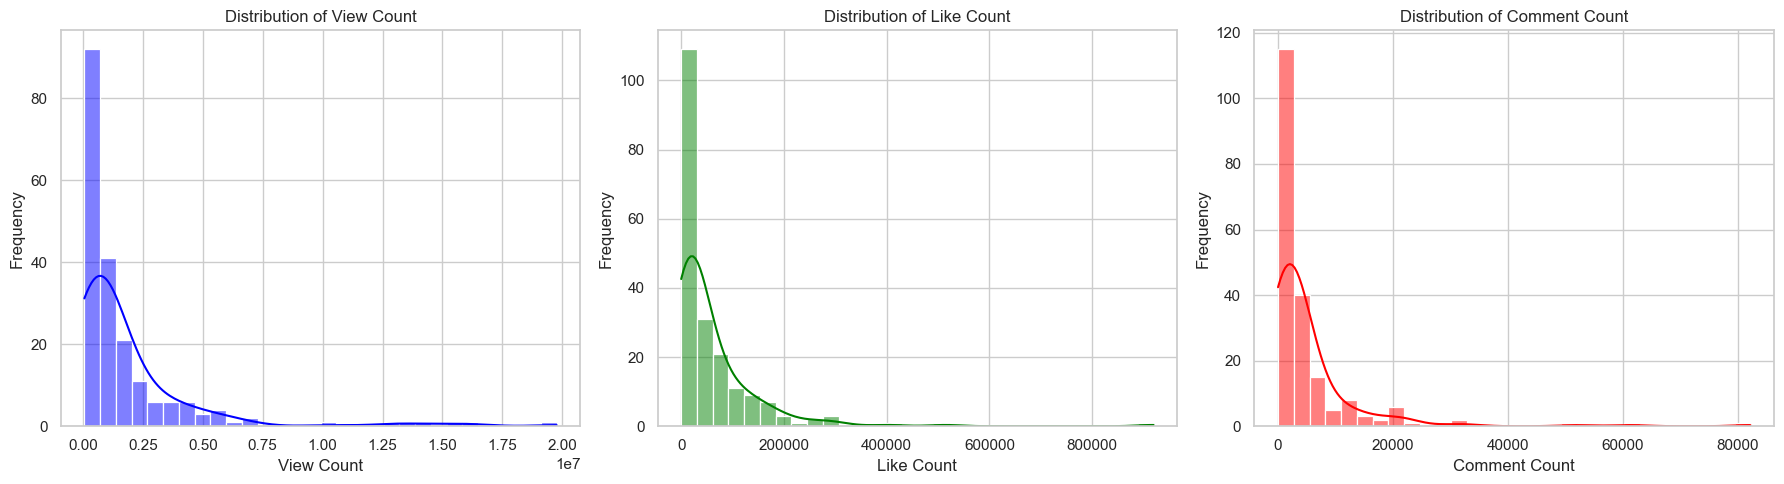

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid")

fig,axes = plt.subplots(1,3,figsize=(18,5))

#view count distribution
sns.histplot(trending_videos['view_count'],bins=30,kde=True,ax=axes[0],color='blue')
axes[0].set_title('Distribution of View Count')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

#like count distribution
sns.histplot(trending_videos['like_count'],bins=30,kde=True,ax=axes[1],color='green')
axes[1].set_title('Distribution of Like Count')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

#comment count distribution
sns.histplot(trending_videos['comment_count'],bins=30,kde=True,ax=axes[2],color='red')
axes[2].set_title('Distribution of Comment Count')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The histograms show that the distributions of view counts, like counts, and comment counts are right-skewed, with most videos having lower counts and a few videos having very high counts. Now, let’s have a look at the correlation between likes, views, and comments:

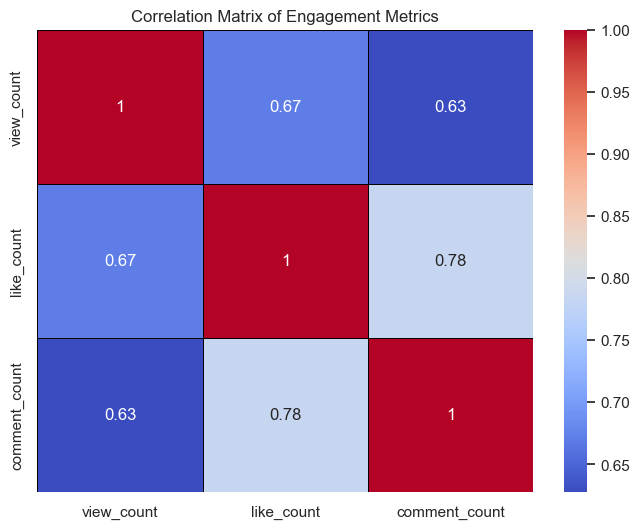

In [8]:
# correlation matrix

correlation_matrix = trending_videos[['view_count','like_count','comment_count']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',linewidths=0.5,linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

The heatmap confirms strong positive correlations between views, likes, and comments.

### So, let’s collect the category names as well to analyze the categories of the trending videos:

In [ ]:
from googleapiclient.discovery import build
API_KEY = "Your-API-Key"

youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part = 'snippet',
        regionCode = 'US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

#get the category mapping
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


Now, here’s how we can analyze the number of trending videos by category:

C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\3605044292.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=trending_videos['categoory_name'],order=trending_videos['categoory_name'].value_counts().index, palette = 'viridis')


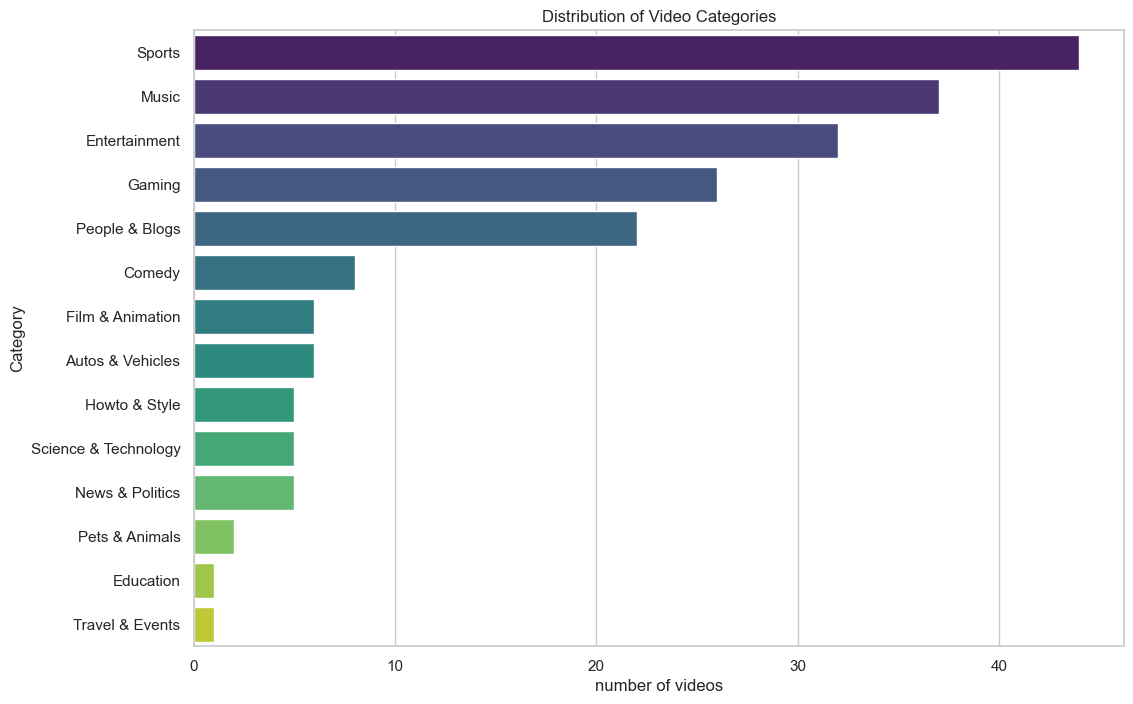

In [10]:
trending_videos['categoory_name'] = trending_videos['category_id'].map(category_mapping)

#bar chart for category counts
plt.figure(figsize=(12,8))
sns.countplot(y=trending_videos['categoory_name'],order=trending_videos['categoory_name'].value_counts().index, palette = 'viridis')
plt.title('Distribution of Video Categories')
plt.xlabel('number of videos')
plt.ylabel('Category')
plt.show()

The bar chart shows that the Gaming, Entertainment, Sports, and Music categories have the highest number of trending videos. Now, let’s have a look at the average engagement metrics by category:

                        view_count     like_count  comment_count
categoory_name                                                  
Education             4.629541e+06  168737.000000   10331.000000
Entertainment         2.728850e+06   71394.125000    5417.906250
Film & Animation      2.443205e+06   92145.666667    6756.500000
Gaming                2.434846e+06   98556.615385   10899.923077
Science & Technology  2.329782e+06   63456.000000    4079.600000
Music                 2.017649e+06   98364.243243    7625.432432
Pets & Animals        1.895156e+06   29998.500000    2188.000000
Howto & Style         1.480905e+06   34818.200000    2393.800000
Sports                1.301365e+06   13819.886364    1936.090909
Comedy                1.115406e+06   50445.500000    2603.125000
Autos & Vehicles      1.103259e+06   43915.000000    2313.500000
People & Blogs        9.120458e+05   34815.363636    3634.863636
News & Politics       5.725048e+05    5487.000000    1993.800000
Travel & Events       3.3

C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\3676310971.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index,x=category_engagement['view_count'],ax=axes[0],palette='viridis')
C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\3676310971.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index,x=category_engagement['like_count'],ax=axes[1],palette='viridis')
C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\3676310971.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_e

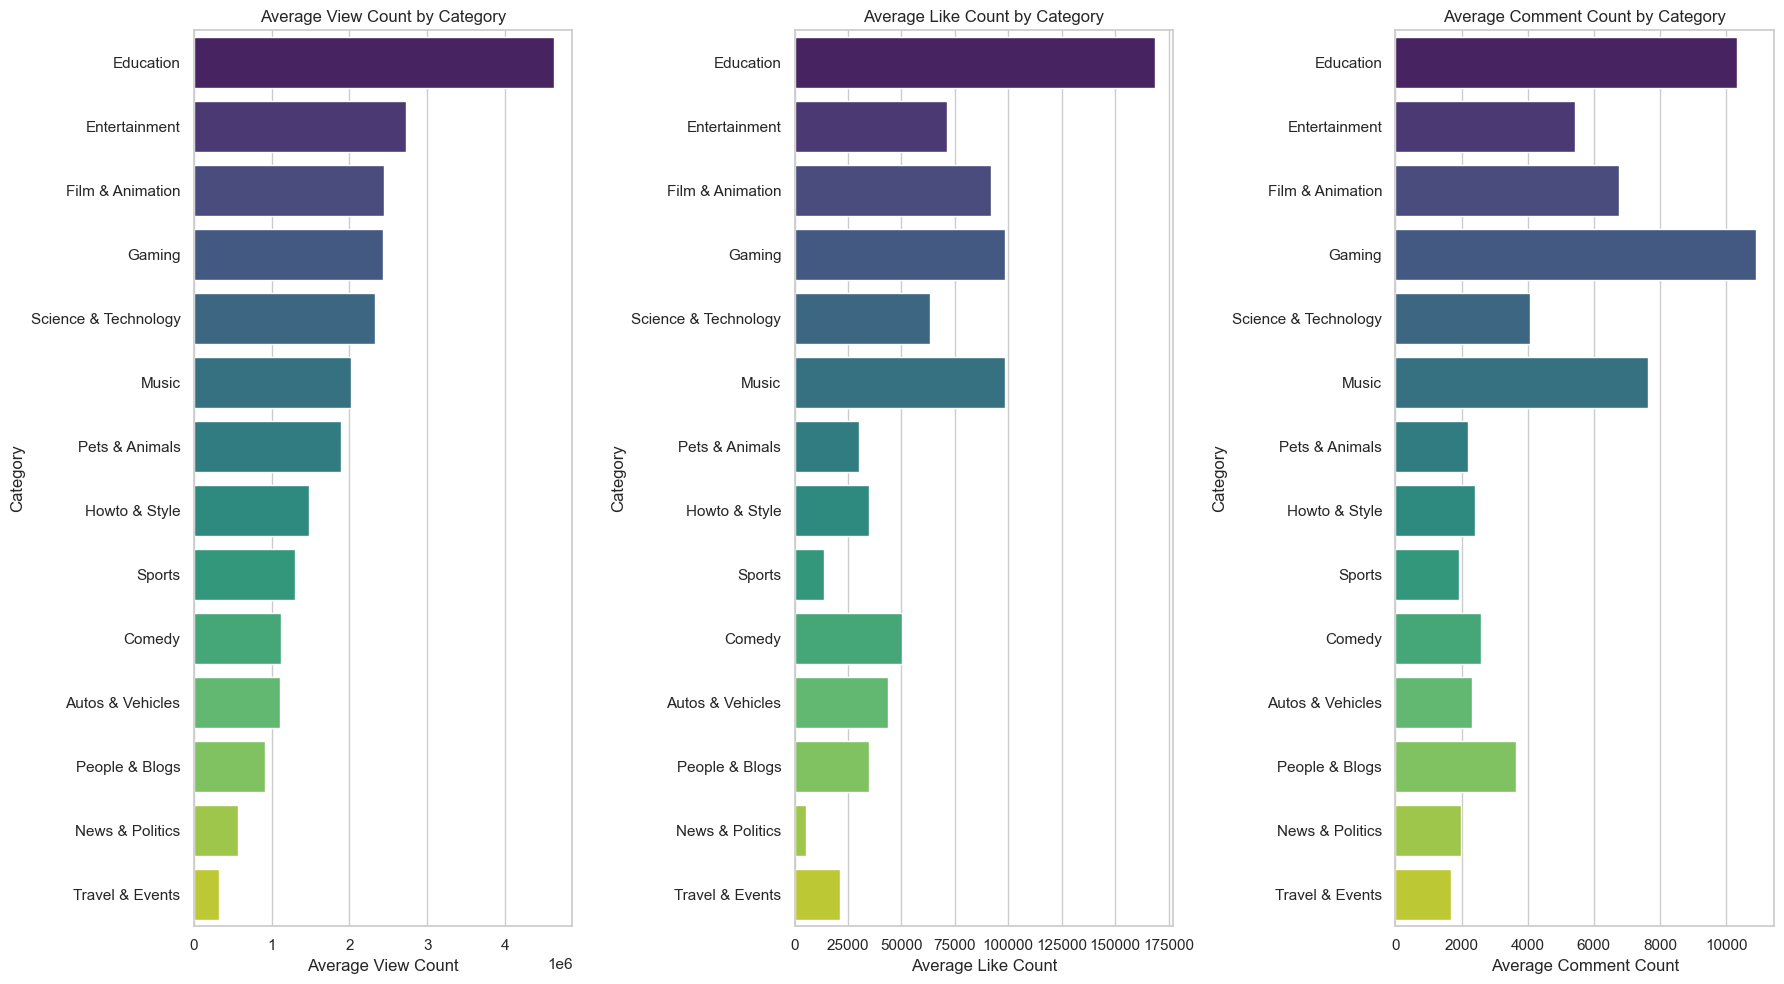

In [11]:
#average engagement metrics by category

category_engagement = trending_videos.groupby('categoory_name')[['view_count','like_count','comment_count']].mean().sort_values(by='view_count',ascending=False)
print(category_engagement)

fig , axes = plt.subplots(1,3,figsize=(18,10))

#view count by category
sns.barplot(y=category_engagement.index,x=category_engagement['view_count'],ax=axes[0],palette='viridis')
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

#like count by category
sns.barplot(y=category_engagement.index,x=category_engagement['like_count'],ax=axes[1],palette='viridis')
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('Category')

#comment count by category
sns.barplot(y=category_engagement.index,x=category_engagement['comment_count'],ax=axes[2],palette='viridis')
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('Category')

plt.tight_layout()
plt.show()


Music and People & Blogs categories have the highest average view counts, likes, and comments. Film & Animation also shows high engagement, especially in view counts and like counts.

### Now, let’s analyze the content and the duration of videos:

In [12]:
import isodate

trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))

trending_videos['duration_range'] = pd.cut(trending_videos['duration_seconds'],bins=[0,300,600,1200,3600,7200],labels=['<5 min','5-10 min','10-20 min','20-60 min','>60 min'])

In the above code, we are using the isodate library to convert the duration of each video from the ISO 8601 format to seconds, which allows for numerical analysis. After converting the durations, we are categorizing the videos into different duration ranges (0-5 minutes, 5-10 minutes, 10-20 minutes, 20-60 minutes, and 60-120 minutes) by creating a new column called duration_range. This categorization enables us to analyze and compare the engagement metrics of videos within specific length intervals, providing insights into how video length influences viewer behaviour and video performance.

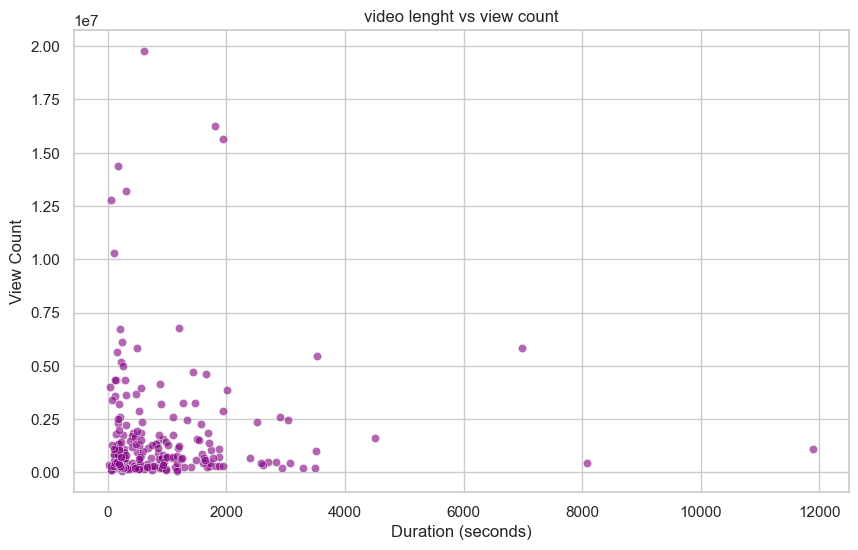

                  view_count     like_count  comment_count
duration_range                                            
>60 min         3.734144e+06  103676.000000    7692.500000
<5 min          2.106764e+06   68797.555556    5523.365079
20-60 min       1.971559e+06   62198.020833    5277.770833
5-10 min        1.598701e+06   76499.179487    5964.384615
10-20 min       1.407680e+06   28561.782609    4031.369565


C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\424820471.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_engagement = trending_videos.groupby('duration_range')[['view_count','like_count','comment_count']].mean().sort_values(by='view_count',ascending=False)


In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='duration_seconds',y='view_count',data=trending_videos,alpha=0.6,color='purple')
plt.title('video lenght vs view count')
plt.xlabel('Duration (seconds)')
plt.ylabel('View Count')
plt.show()

#bar chart for engagement metrics by duration range
length_engagement = trending_videos.groupby('duration_range')[['view_count','like_count','comment_count']].mean().sort_values(by='view_count',ascending=False)
print(length_engagement)


C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\3651957124.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.index,x=length_engagement['view_count'],ax=axes[0],palette='magma')
C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\3651957124.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.index,x=length_engagement['like_count'],ax=axes[1],palette='magma')
C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\3651957124.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.inde

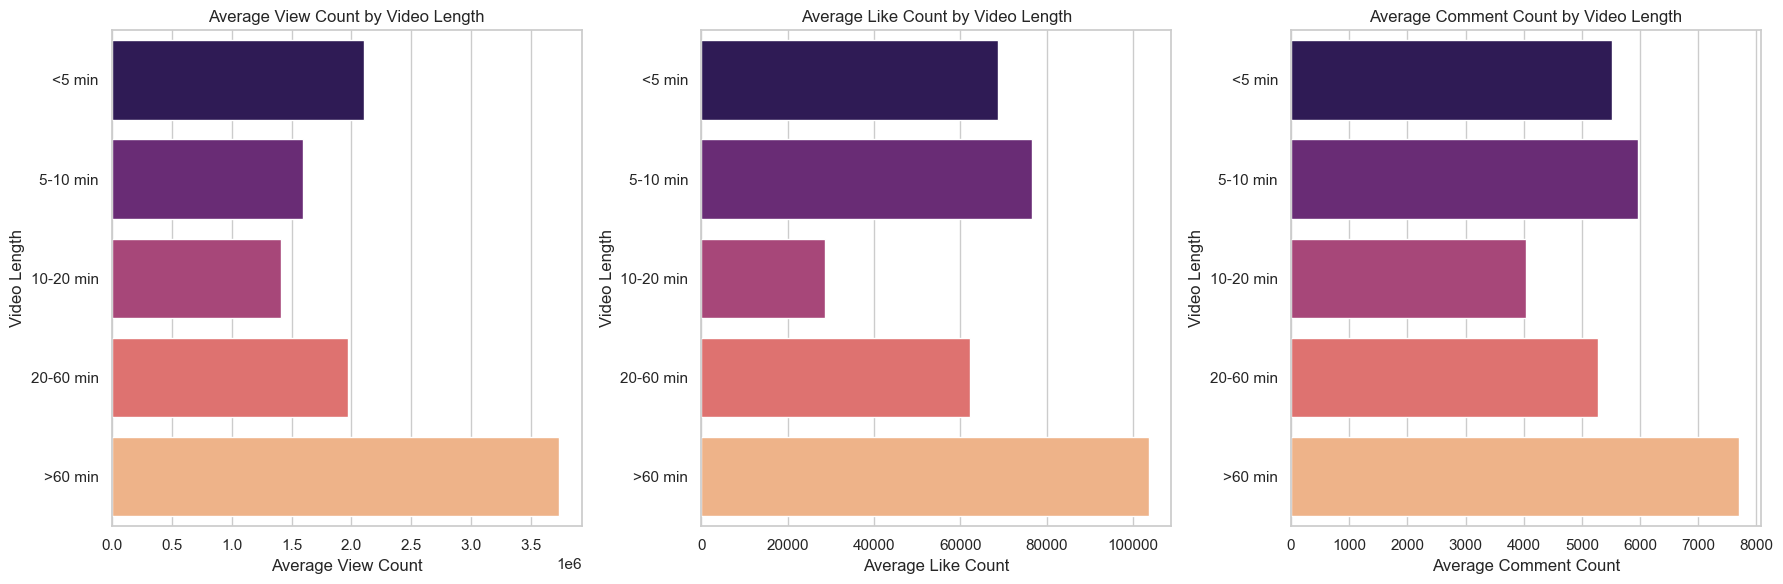

In [14]:
#bar chart for engagement metrics by duration range
fig,axes = plt.subplots(1,3,figsize=(18,6))

#view count by duration range
sns.barplot(y=length_engagement.index,x=length_engagement['view_count'],ax=axes[0],palette='magma')
axes[0].set_title('Average View Count by Video Length')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Video Length')

#like count by duration range
sns.barplot(y=length_engagement.index,x=length_engagement['like_count'],ax=axes[1],palette='magma')
axes[1].set_title('Average Like Count by Video Length')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('Video Length')

#comment count by duration range
sns.barplot(y=length_engagement.index,x=length_engagement['comment_count'],ax=axes[2],palette='magma')
axes[2].set_title('Average Comment Count by Video Length')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('Video Length')

plt.tight_layout()
plt.show()

The scatter plot shows a slight negative correlation between video length and view count, indicating shorter videos tend to have higher view counts. Videos in the 0-5 minute range have the highest average view counts, likes, and comments. Engagement decreases as video length increases.

### Now, let’s see if there’s an impact of the time a video is posted on its views:

C:\Users\keerthi\AppData\Local\Temp\ipykernel_20360\1124766084.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='publish_hour', data=trending_videos, alpha=0.6, palette='viridis')


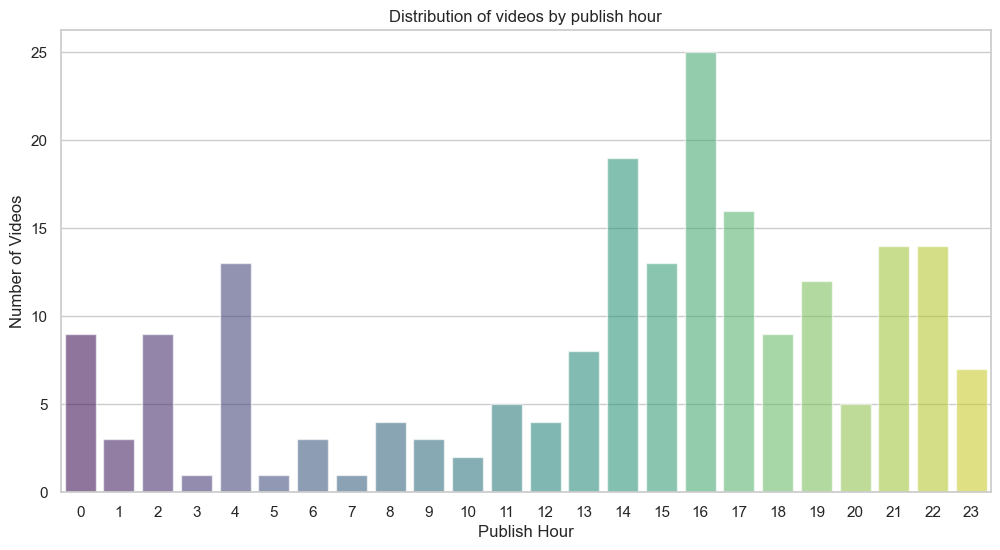

In [15]:
# extract hour of publication

trending_videos['publish_hour'] = trending_videos['published_at'].dt.hour

# bar chart for publish hour distribution
plt.figure(figsize=(12,6))
sns.countplot(x='publish_hour', data=trending_videos, alpha=0.6, palette='viridis')
plt.title('Distribution of videos by publish hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()

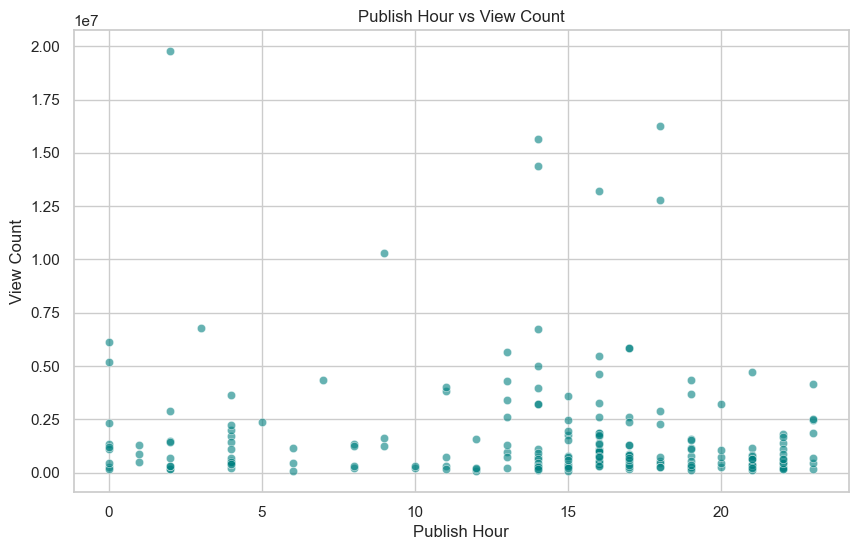

In [16]:
# scatter plot for publish hour vs view count
plt.figure(figsize=(10,6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

The distribution shows that most videos are published between 14:00 and 20:00 hours (2 PM – 8 PM), indicating this may be an optimal time for uploading videos. There is a very weak negative relationship between publish hour and view count, suggesting that the hour of publication has minimal impact on engagement metrics.

### Conclusion

So, here’s my conclusion on what makes a video trend on YouTube:

Encourage viewers to like and comment on videos to boost engagement metrics.
Aim to create shorter videos (under 5 minutes) for higher engagement, especially for categories like Music and Entertainment.
Schedule video uploads around peak times (2 PM – 8 PM) to maximize initial views and engagement.